# Загрузка данных

In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving TrainP.pkl to TrainP.pkl


In [ ]:
!unzip text.zip

Archive:  text.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Предварительный анализ данных

Russian Social Media Text Classification
[ссылка](https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification)

In [ ]:
Train = pd.read_csv('../content/train.csv')

Test = pd.read_csv('../content/test.csv')

Пример строки

In [ ]:
Train['text'][1230]

'Дуэль звезд Роберт Райхел vs Бобби Холик Чешские форварды из НХЛ прошлых лет. Выбираем 33 P. S. Предлагайте свои варианты Дуэлей. Добавляйте свой пост в окно Предложить новость. Самые интересные обязательно опубликуем. Спасибо 33'

## Уникальные слова

In [ ]:
results = Counter()
Train['text'].str.split().apply(results.update)

0        None
1        None
2        None
3        None
4        None
         ... 
38735    None
38736    None
38737    None
38738    None
38739    None
Name: text, Length: 38740, dtype: object

In [ ]:
len(results)

201198

In [ ]:
sum(np.array(list(results.values()))>10)

22277

При этом примерно 180 000 встречаются меньше 10 раз

## Проверка сбалансированности классов документов в имеющемся наборе

In [ ]:
# Метки классов и частоты их встречаемости в наборе
nn = np.unique(Train['category'], return_counts = True)
nn

(array(['athletics', 'autosport', 'basketball', 'boardgames', 'esport',
        'extreme', 'football', 'hockey', 'martial_arts', 'motosport',
        'tennis', 'volleyball', 'winter_sport'], dtype=object),
 array([2970, 3160, 2850, 3020, 2990, 3110, 2860, 2950, 3050, 3030, 3000,
        2950, 2800]))

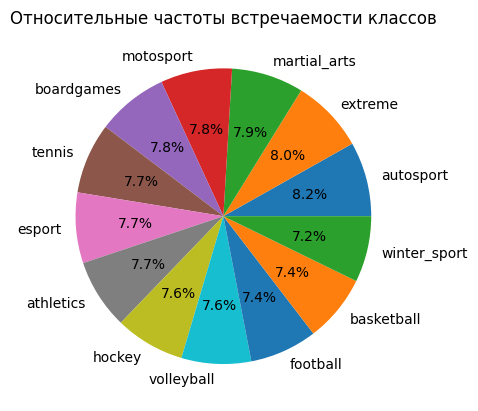

In [ ]:
Train['category'].value_counts().plot(kind='pie', title='Относительные частоты встречаемости классов', autopct='%1.1f%%')
plt.axis('off')
plt.show()

# Предварительная обработка текста

Удалим знаки

In [ ]:
punctuation_marks = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '@', ';', '/', "''", "``",'№','«','»','–']

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def preprocess_1(text, punctuation_marks, morph):
    tokens = word_tokenize(text.lower().replace('ё', 'e'))
    text_norm = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            text_norm.append(lemma)
    return text_norm

In [ ]:
Train['text_norm'] = Train.apply(lambda row: preprocess_1(row['text'], punctuation_marks, morph), axis=1)

In [ ]:
Train['text_norm'][1905]

['чемпионат',
 'турция',
 'финал',
 'матч',
 '4.',
 'фенербхач',
 'вакыфбанк',
 'счёт',
 'в',
 'серия',
 '2',
 '1.',
 'начало',
 'в',
 '19',
 '00']

Удаление стоп слов

In [ ]:
def preprocess_2(list, stop_words):
    preprocessed_text = []
    for token in list:
        if token not in stop_words:
            preprocessed_text.append(token)
    return preprocessed_text

In [ ]:
stop_words = stopwords.words("russian")
stop_words

In [ ]:
Train['text_remove_stop'] = Train.apply(lambda row: preprocess_2(row['text_norm'], stop_words), axis=1)

In [ ]:
Train

,oid,category,text,text_norm,text_remove_stop
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,"[волшебный, фото, виктория, поплавский, евгени...","[волшебный, фото, виктория, поплавский, евгени..."
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,"[возвращение, в, подземелье, треш, 33, эйфория...","[возвращение, подземелье, треш, 33, эйфория, т..."
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,"[хороший, чешский, вратарь, доминик, доминатор...","[хороший, чешский, вратарь, доминик, доминатор..."
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,"[rtokenoid, warhammer40k, валрак, решить, мы, ...","[rtokenoid, warhammer40k, валрак, решить, подк..."
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,"[шестёркин, затаскивать, рейнджерс, в, финал, ...","[шестёркин, затаскивать, рейнджерс, финал, вос..."
...,...,...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...,"[8, битный, буря, снова, накрыть, пиксель, авт...","[8, битный, буря, снова, накрыть, пиксель, авт..."
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...,"[ир, сидоркова, объяснять, как, сказаться, на,...","[ир, сидоркова, объяснять, сказаться, машина, ..."
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...,"[24, я, ракетка, мир, хорват, марин, чилич, об...","[24, ракетка, мир, хорват, марин, чилич, обыгр..."
38738,776944963,volleyball,Стал известен календарь мужской сборной России...,"[стать, известный, календарь, мужской, сборная...","[стать, известный, календарь, мужской, сборная..."


Сохраним

In [ ]:
Train[['oid','category','text_remove_stop']].to_pickle('/content/TrainP.csv')

# Визуализация

## Облако слов

In [ ]:
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

In [ ]:
words = []
for w in Train['text_remove_stop'].values:
    words+=w

mostcommon = FreqDist(words).most_common(100)

wordcloud = WordCloud(width=600, height=400, background_color='black').generate(str(mostcommon).replace("'",""))

In [ ]:
mostcommon

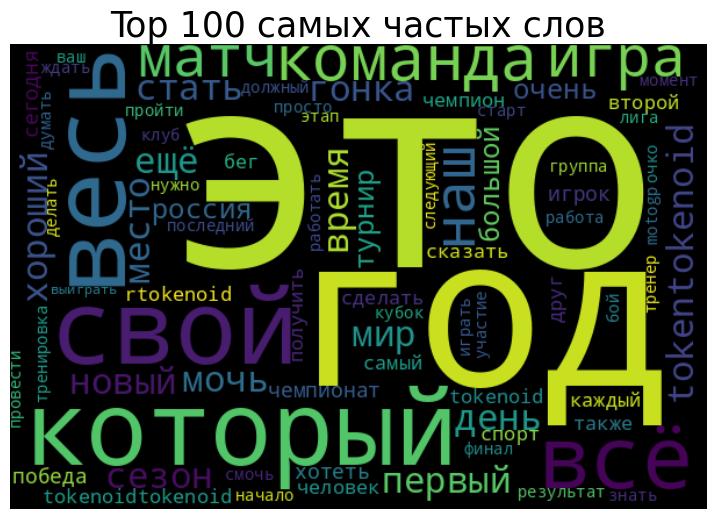

In [ ]:
fig = plt.figure(figsize=(10,5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 самых частых слов', fontsize=25)
plt.tight_layout(pad=0)
plt.show()

## Условная встречаемость

In [ ]:
from collections import Counter

In [ ]:
def plot_freq(words, freqs, category):
    plt.figure(figsize=(15,4))
    plt.bar(words, freqs)
    plt.xlabel('слова')
    plt.ylabel('частоты слов')
    plt.title(f'частоты встречаемости 20 слов для {category}', fontsize=20)
    plt.yticks(fontsize=10)
    plt.xticks(rotation=60, fontsize=10)
    plt.show()


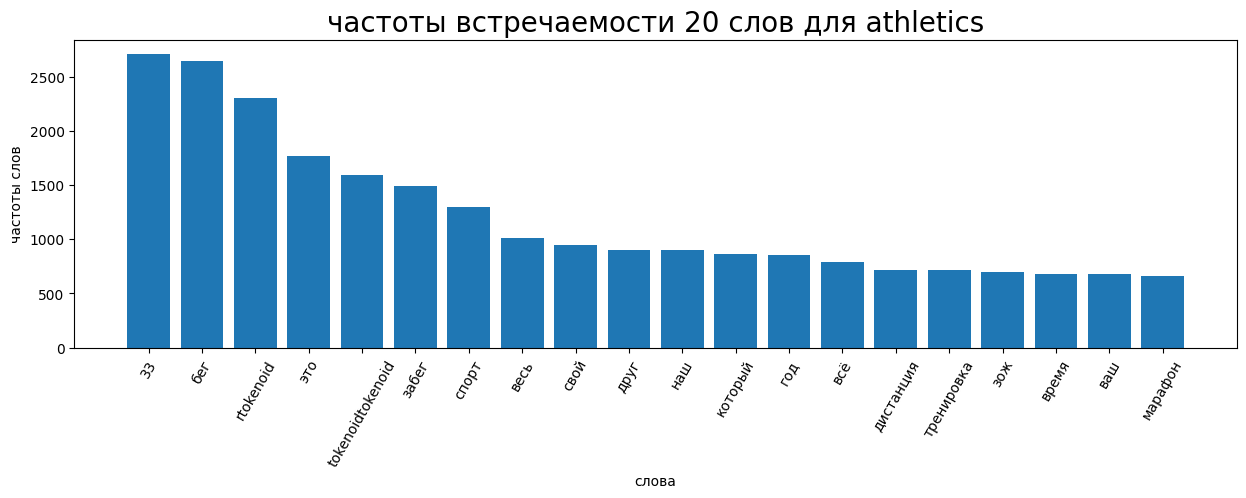

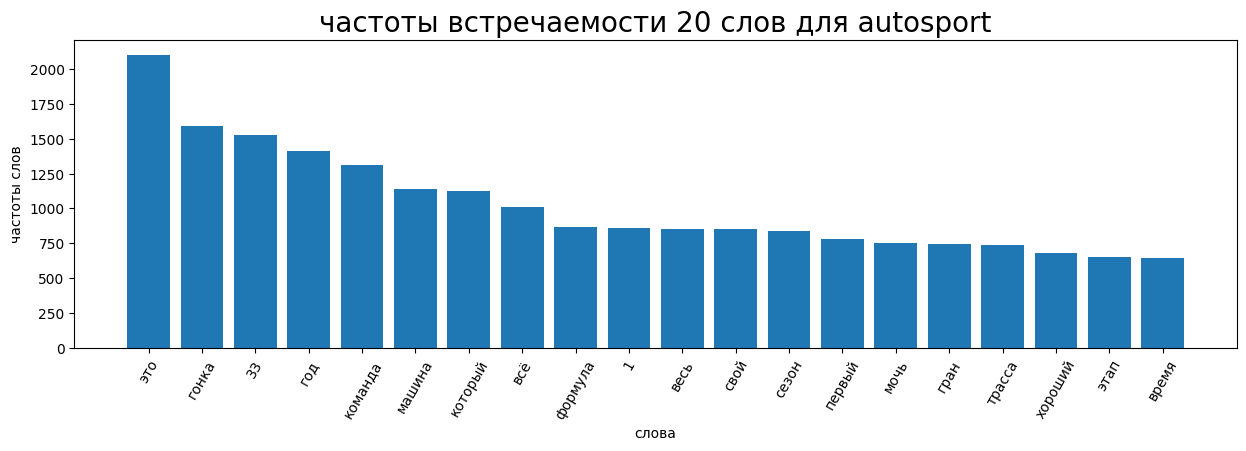

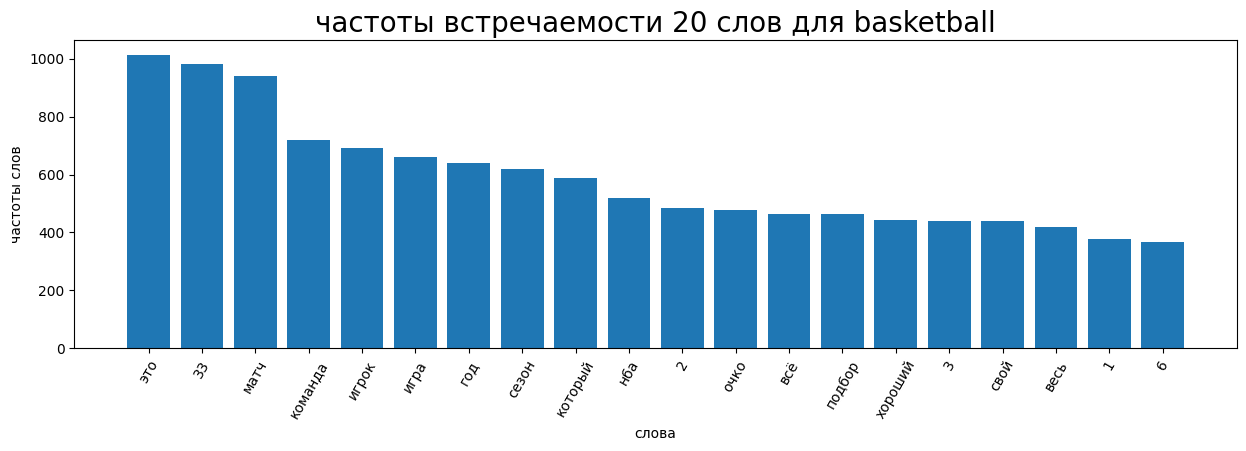

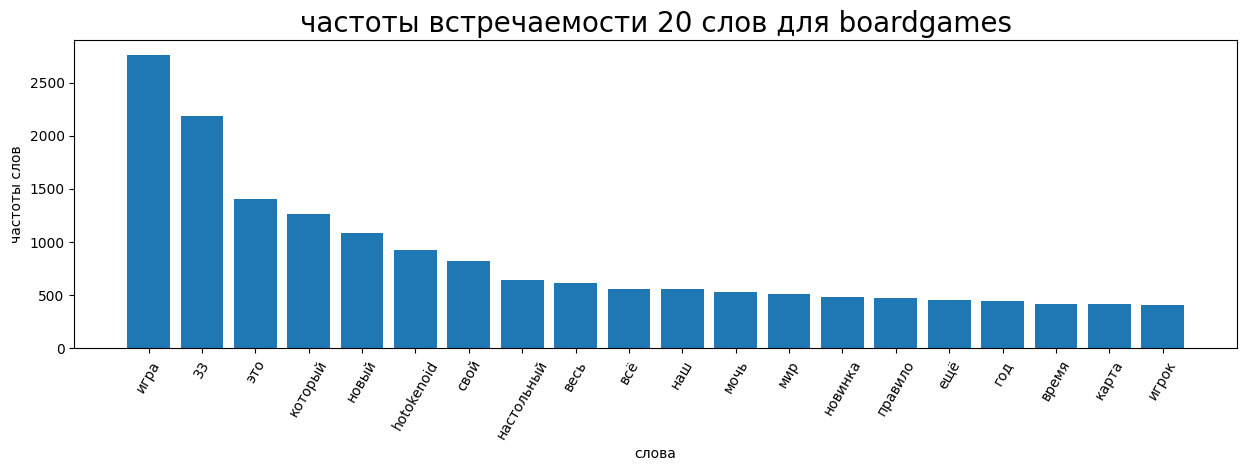

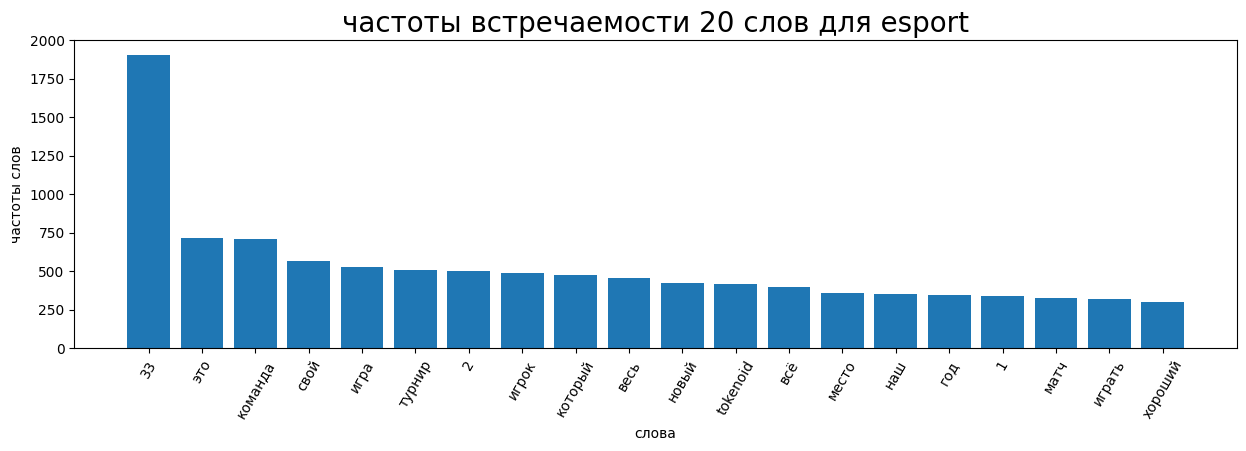

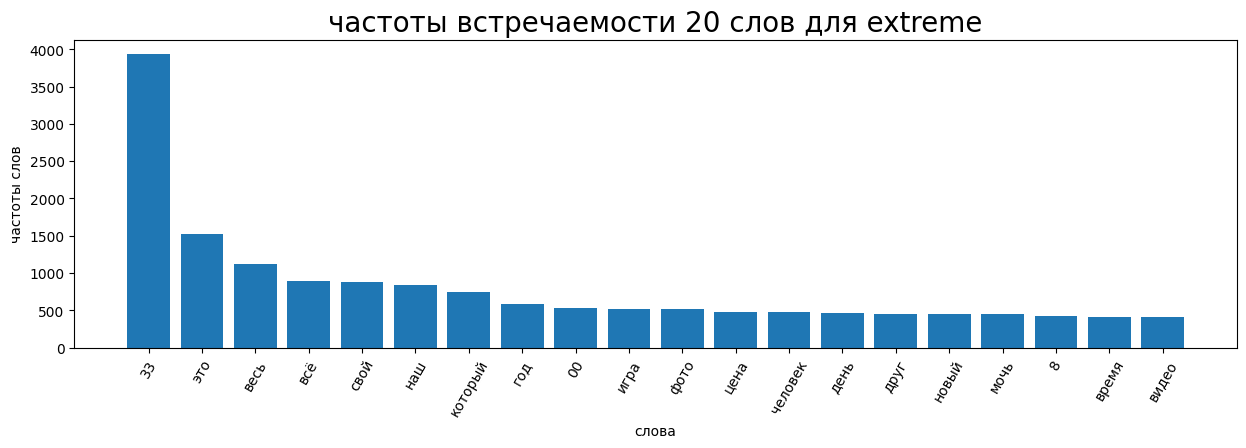

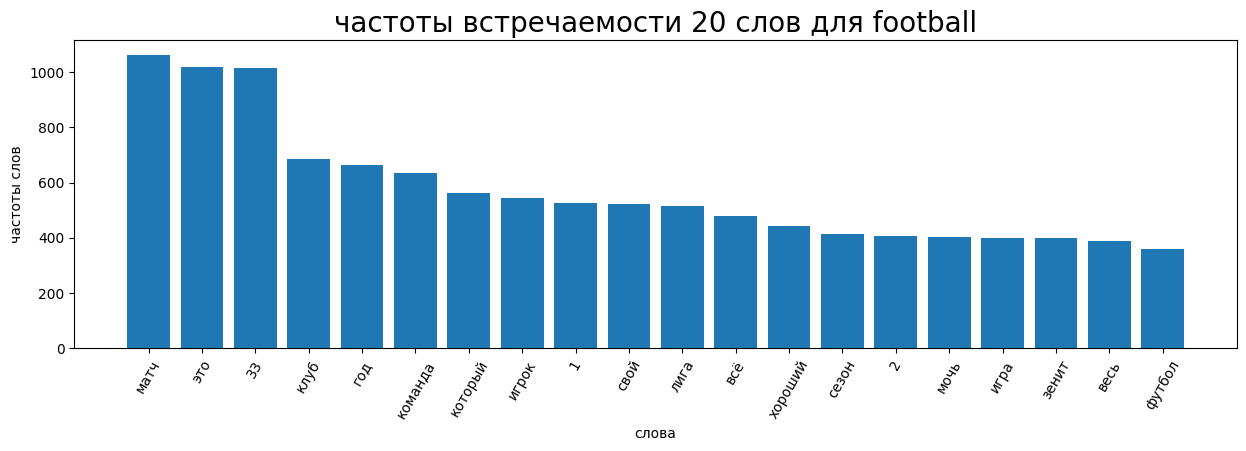

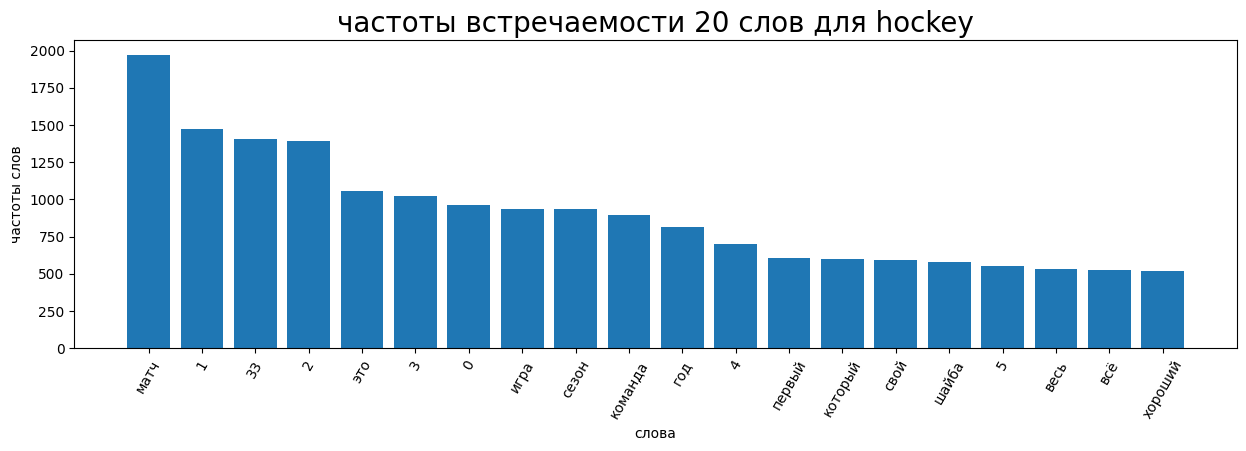

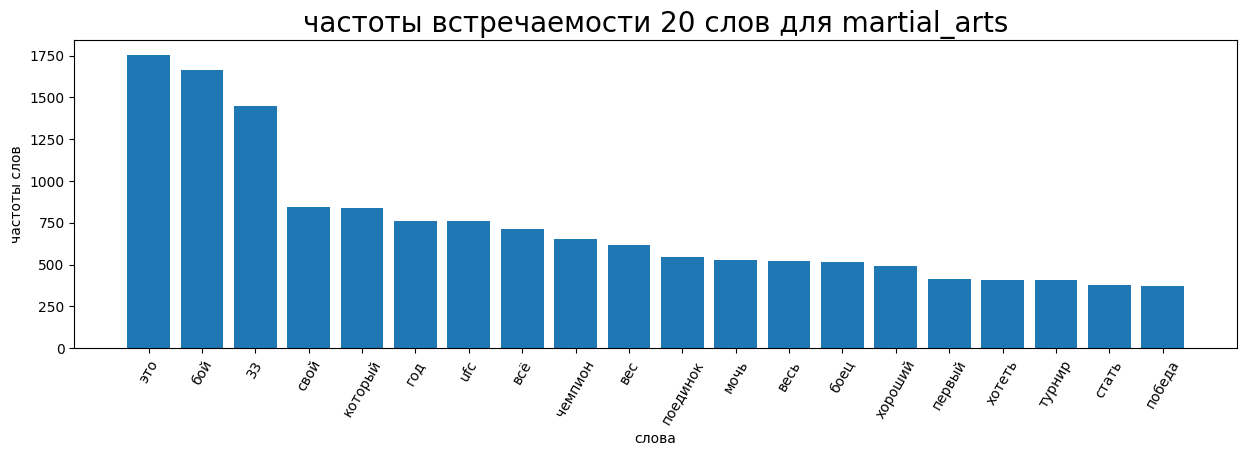

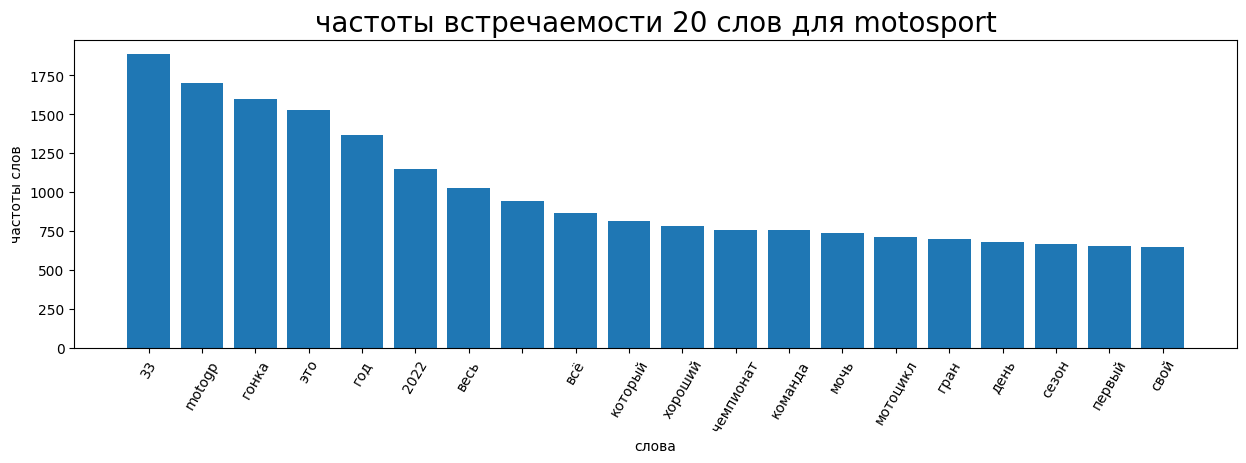

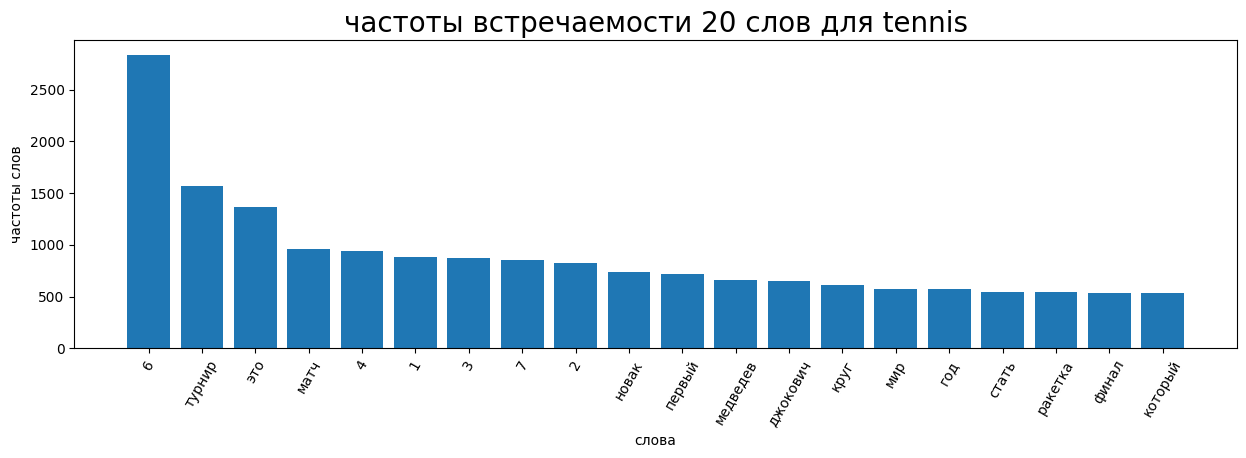

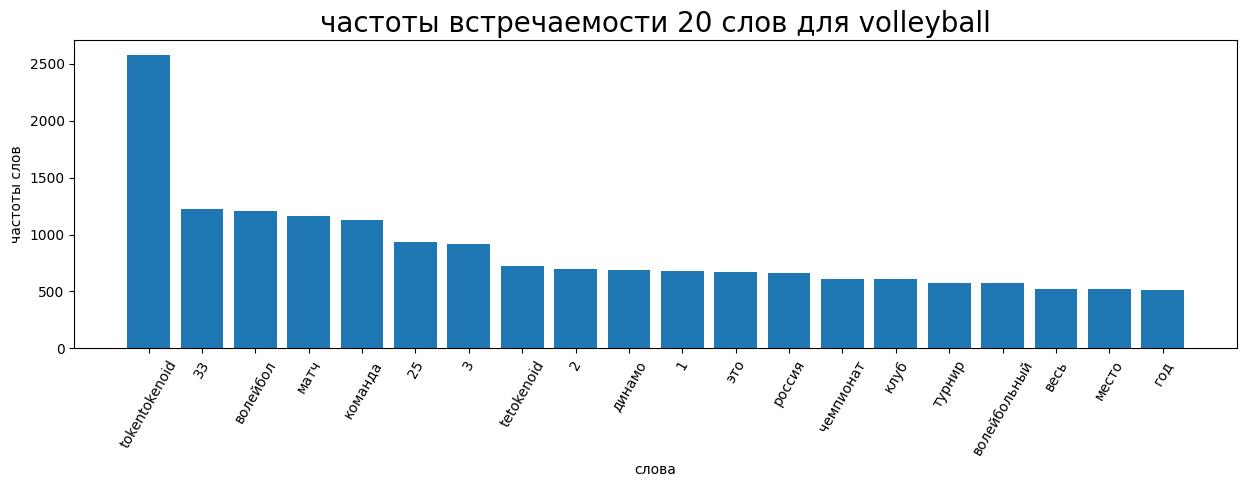

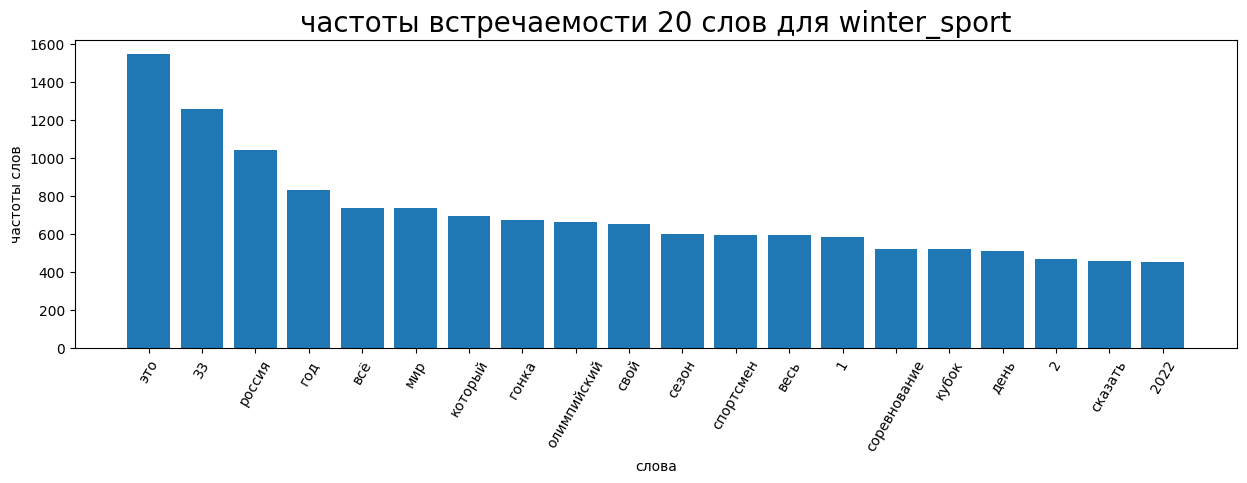

In [ ]:
Train['lemmatized_str'] = Train['text_remove_stop'].apply(lambda row: ' '.join(row))
group_by = Train.groupby('category')['lemmatized_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(20))

words = [list(zip(*group_by.iloc[i]))[0] for i in range(13)]
freqs = [list(zip(*group_by.iloc[i]))[1] for i in range(13)]

plot_freq(words[0], freqs[0], 'athletics')
plot_freq(words[1], freqs[1], 'autosport')
plot_freq(words[2], freqs[2], 'basketball')
plot_freq(words[3], freqs[3], 'boardgames')
plot_freq(words[4], freqs[4], 'esport')
plot_freq(words[5], freqs[5], 'extreme')
plot_freq(words[6], freqs[6], 'football')
plot_freq(words[7], freqs[7], 'hockey')
plot_freq(words[8], freqs[8], 'martial_arts')
plot_freq(words[9], freqs[9], 'motosport')
plot_freq(words[10], freqs[10], 'tennis')
plot_freq(words[11], freqs[11], 'volleyball')
plot_freq(words[12], freqs[12], 'winter_sport')


# TFIDF

In [ ]:
from sklearn import feature_extraction

In [ ]:
Train

,oid,category,text,text_norm,text_remove_stop,lemmatized_str
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,"[волшебный, фото, виктория, поплавский, евгени...","[волшебный, фото, виктория, поплавский, евгени...",волшебный фото виктория поплавский евгениямедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,"[возвращение, в, подземелье, треш, 33, эйфория...","[возвращение, подземелье, треш, 33, эйфория, т...",возвращение подземелье треш 33 эйфория тупость...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,"[хороший, чешский, вратарь, доминик, доминатор...","[хороший, чешский, вратарь, доминик, доминатор...",хороший чешский вратарь доминик доминатор гаше...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,"[rtokenoid, warhammer40k, валрак, решить, мы, ...","[rtokenoid, warhammer40k, валрак, решить, подк...",rtokenoid warhammer40k валрак решить подкормит...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,"[шестёркин, затаскивать, рейнджерс, в, финал, ...","[шестёркин, затаскивать, рейнджерс, финал, вос...",шестёркин затаскивать рейнджерс финал восточны...
...,...,...,...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...,"[8, битный, буря, снова, накрыть, пиксель, авт...","[8, битный, буря, снова, накрыть, пиксель, авт...",8 битный буря снова накрыть пиксель автомобиль...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...,"[ир, сидоркова, объяснять, как, сказаться, на,...","[ир, сидоркова, объяснять, сказаться, машина, ...",ир сидоркова объяснять сказаться машина резуль...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...,"[24, я, ракетка, мир, хорват, марин, чилич, об...","[24, ракетка, мир, хорват, марин, чилич, обыгр...",24 ракетка мир хорват марин чилич обыграть исп...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...,"[стать, известный, календарь, мужской, сборная...","[стать, известный, календарь, мужской, сборная...",стать известный календарь мужской сборная росс...


Создаем объект

In [ ]:
corpus = Train["lemmatized_str"]
len(set(corpus))

35713

In [ ]:
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=30000, ngram_range=(1,2))

## TFIDF model

Обучаем объект

In [ ]:
tfidf_vectorizer.fit(corpus)
X_train_tfidf = tfidf_vectorizer.transform(corpus)
dic_vocabulary_tfidf = tfidf_vectorizer.vocabulary_

In [ ]:
dic_vocabulary_tfidf

In [ ]:
print(X_train_tfidf)

In [ ]:
pd.DataFrame(X_train_tfidf[0].todense())

,0,1,2,3,4,5,6,7,8,9,...,29990,29991,29992,29993,29994,29995,29996,29997,29998,29999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Разбивааем на обучающие и тестовые выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, Train['category'],
                                                    stratify = Train['category'], random_state = 20)

# Обучение модели деревьев решений (Случайный лес)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

In [ ]:
RForest = RandomForestClassifier(min_samples_leaf=10, min_samples_split=14,
                                max_features=15, n_estimators=15)

RForest.fit(X_train, y_train)

RandomForestClassifier(max_features=15, min_samples_leaf=10,
                       min_samples_split=14, n_estimators=15)

Оценим модель

In [ ]:
cores = cross_val_score(RForest, X_train, y_train, cv=2, scoring='f1_macro')
print(cores)

[0.47794588 0.39065766]


In [ ]:
cores_m = cross_val_score(RForest, X_train, y_train, cv=2, scoring='neg_log_loss')
print(cores_m)

[-2.30910831 -2.32340884]


In [ ]:
cores_p = cross_val_score(RForest, X_train, y_train, cv=2, scoring='f1_micro')
print(cores_p)

[0.37630782 0.43532732]


## Оптимизация модели

### Подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV
dt = RandomForestClassifier()
params = {
          'min_samples_leaf':[15,55],
          'min_samples_split':[5,55],
          'max_features':[500,1200] ,
          'n_estimators': [5,55]


}
search = GridSearchCV(dt, param_grid=params, cv=5, scoring='f1_macro')
search.fit(X_train, y_train)
print(search.best_estimator_)
print(search.best_params_)

RandomForestClassifier(max_features=500, min_samples_leaf=15,
                       min_samples_split=55, n_estimators=55)
{'max_features': 500, 'min_samples_leaf': 15, 'min_samples_split': 55, 'n_estimators': 55}


### Обучение модели на подобронных гиперпараметрах

In [ ]:
RForest = RandomForestClassifier(min_samples_leaf=15, min_samples_split=55,
                                max_features=500, n_estimators=55)

RForest.fit(X_train, y_train)

RandomForestClassifier(max_features=500, min_samples_leaf=15,
                       min_samples_split=55, n_estimators=55)

In [ ]:
y_predict=RForest.predict(X_test)

Оценим модель

In [ ]:
cores = cross_val_score(RForest, X_train, y_train, cv=2, scoring='f1_macro')
print('f1_macro',cores)

cores_m = cross_val_score(RForest, X_train, y_train, cv=2, scoring='neg_log_loss')
print('neg_log_loss',cores_m)

cores_p = cross_val_score(RForest, X_train, y_train, cv=2, scoring='f1_micro')
print('f1_micro:',cores_p)

f1_macro [0.67561457 0.67597554]
neg_log_loss [-1.32036446 -1.29517316]
f1_micro: [0.66719438 0.66937427]


За счет подбора отпитмальных гиперпараметров точность модели по метрике f1_macro увеличилась примерно в два раза

### Оценка на тестовой выборке

In [ ]:
cores = cross_val_score(RForest, X_test, y_test, cv=2, scoring='f1_macro')
print('f1_macro',cores)

cores_m = cross_val_score(RForest, X_test, y_test, cv=2, scoring='neg_log_loss')
print('neg_log_loss',cores_m)

cores_p = cross_val_score(RForest, X_test, y_test, cv=2, scoring='f1_micro')
print('f1_micro:',cores_p)

f1_macro [0.60280198 0.60642661]
neg_log_loss [-1.64209578 -1.62082968]
f1_micro: [0.59364031 0.61441553]


Матрица ошибок

In [ ]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(16,10))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

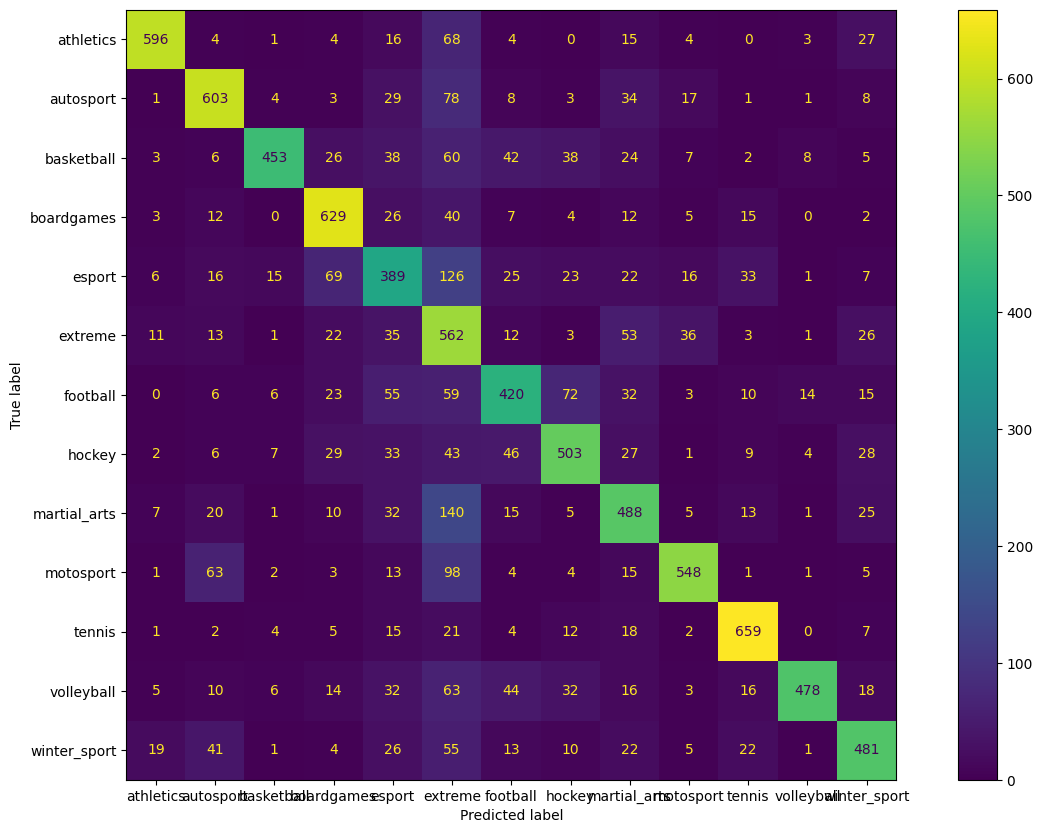

In [ ]:
plot_confusion_matrix(y_test, y_predict,RForest)

## SVC

In [ ]:
from sklearn.svm import LinearSVC
SVC = LinearSVC(random_state=20)
SVC.fit(X_train, y_train)


LinearSVC(random_state=20)

In [ ]:
y_predictSVC=SVC.predict(X_test)

In [ ]:
coresS = cross_val_score(SVC, X_train, y_train, cv=2, scoring='f1_macro')
print(coresS)

[0.85118223 0.85277436]


На тестовой выборке

In [ ]:
coresS = cross_val_score(SVC, X_test, y_test, cv=2, scoring='f1_macro')
print(coresS)

[0.80325769 0.80396147]


Модель SVC оказалась точнее случайного леса

Матрица ошибок

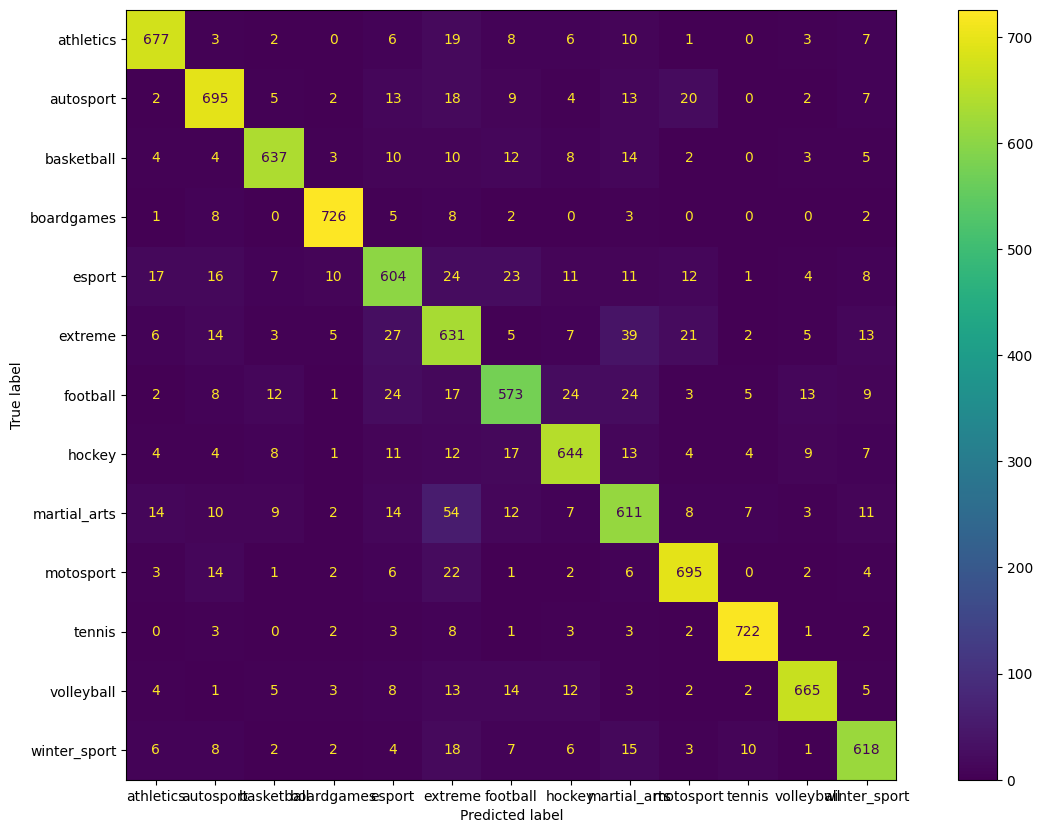

In [ ]:
p = plot_confusion_matrix(y_test, y_predictSVC, SVC)

# Нейросетевой подход

Разобъем данные на тренировочную и тестовую

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(Train,  test_size=0.25,
                                     stratify = Train['category'],
                                     random_state = 40)

In [ ]:
from sklearn import preprocessing as prep

In [ ]:
train_df

,oid,category,text,text_norm,text_remove_stop,lemmatized_str
35208,64138664,winter_sport,В горах Сочи выпало 38 сантиметров снега В гор...,"[в, гора, сочи, выпасть, 38, сантиметр, снег, ...","[гора, сочи, выпасть, 38, сантиметр, снег, гор...",гора сочи выпасть 38 сантиметр снег гора сочи ...
10797,217403867,tennis,Екатерина Александрова обыграла Дарью Касаткин...,"[екатерина, александров, обыграть, дарья, каса...","[екатерина, александров, обыграть, дарья, каса...",екатерина александров обыграть дарья касаткин ...
25517,296504568,autosport,Гран При Австрии 2022 пятничная Квалификация V...,"[гран, при, австрия, 2022, пятничный, квалифик...","[гран, австрия, 2022, пятничный, квалификация,...",гран австрия 2022 пятничный квалификация ver l...
14150,885171158,hockey,️Словацкий защитник Кристиан Ярош и канадский ...,"[️словацкий, защитник, кристиан, ярош, и, кана...","[️словацкий, защитник, кристиан, ярош, канадск...",️словацкий защитник кристиан ярош канадский фо...
989,672756054,tennis,РУБЛЁВ ШАГНУЛ В ТРЕТИЙ КРУГ Россиянин Андрей Р...,"[рублeть, шагнуть, в, третий, круг, россиянин,...","[рублeть, шагнуть, третий, круг, россиянин, ан...",рублeть шагнуть третий круг россиянин андрей р...
...,...,...,...,...,...,...
24983,910301063,motosport,Лавина из мотоэкипировки 33 Цунами из скидок 3...,"[лавина, из, мотоэкипировка, 33, цунами, из, с...","[лавина, мотоэкипировка, 33, цунами, скидка, 3...",лавина мотоэкипировка 33 цунами скидка 33 ⠀ по...
37590,98269251,autosport,Заслуженные победители ULD GYMKHANA 2022 Побед...,"[заслужить, победитель, uld, gymkhana, 2022, п...","[заслужить, победитель, uld, gymkhana, 2022, п...",заслужить победитель uld gymkhana 2022 победит...
16216,272151777,motosport,MotoGP Зарко Я быстр на Dtokenoid но при этом ...,"[motogp, зарко, я, быстрый, на, dtokenoid, но,...","[motogp, зарко, быстрый, dtokenoid, это, очень...",motogp зарко быстрый dtokenoid это очень рассл...
8634,670462469,hockey,Овечкин попал Кузнецову клюшкой по лицу в матч...,"[овечкин, попасть, кузнецов, клюшка, по, лицо,...","[овечкин, попасть, кузнецов, клюшка, лицо, мат...",овечкин попасть кузнецов клюшка лицо матч сент...


In [ ]:
test_df

,oid,category,text,text_norm,text_remove_stop,lemmatized_str
38191,542683871,extreme,ЧИТАЕМ ПОСТ ДО КОНЦА Сегодня 5 июня полеты тол...,"[читаемый, пост, до, конец, сегодня, 5, июнь, ...","[читаемый, пост, конец, сегодня, 5, июнь, полё...",читаемый пост конец сегодня 5 июнь полёт мотоп...
23990,293792080,football,Fatokenoid Romano Тоттенхэм и Лестер заинтерес...,"[fatokenoid, romano, тоттенхэма, и, лестер, за...","[fatokenoid, romano, тоттенхэма, лестер, заинт...",fatokenoid romano тоттенхэма лестер заинтересо...
12496,333280796,martial_arts,ПРЕДПОЛАГАЕМАЯ ДАТА БОЯ 4 ИЮНЯ 33 Обычный и фр...,"[предполагать, дата, бой, 4, июнь, 33, обычный...","[предполагать, дата, бой, 4, июнь, 33, обычный...",предполагать дата бой 4 июнь 33 обычный франча...
9000,120110455,extreme,Когда решил сделать офигительное видео но что ...,"[когда, решить, сделать, офигительный, видео, ...","[решить, сделать, офигительный, видео, пойти]",решить сделать офигительный видео пойти
18361,699009098,motosport,Родители пообещали поехать в салон утром выбра...,"[родитель, пообещать, поехать, в, салон, утром...","[родитель, пообещать, поехать, салон, утром, в...",родитель пообещать поехать салон утром выбрать...
...,...,...,...,...,...,...
29805,295024054,esport,Сегодня свой день рождение отмечает Артем kron...,"[сегодня, свой, день, рождение, отмечать, артё...","[сегодня, свой, день, рождение, отмечать, артё...",сегодня свой день рождение отмечать артём kron...
26647,3738599,winter_sport,Евгений Плющенко о выступлении Вероники Жилино...,"[евгений, плющенко, о, выступление, вероника, ...","[евгений, плющенко, выступление, вероника, жил...",евгений плющенко выступление вероника жилин ма...
20771,382880893,basketball,Порвал задницу за команду Энтони Дэвис в после...,"[порвать, задница, за, команда, энтони, дэвис,...","[порвать, задница, команда, энтони, дэвис, пос...",порвать задница команда энтони дэвис последний...
29831,452235972,tennis,Даниил Медведев ответил чем вызвано то что он ...,"[даниил, медведев, ответить, чем, вызвать, то,...","[даниил, медведев, ответить, вызвать, находить...",даниил медведев ответить вызвать находиться хо...


### Метки классов в цифры

In [ ]:
Label = prep.LabelEncoder().fit(Train['category'])
Label.classes_

array(['athletics', 'autosport', 'basketball', 'boardgames', 'esport',
       'extreme', 'football', 'hockey', 'martial_arts', 'motosport',
       'tennis', 'volleyball', 'winter_sport'], dtype=object)

In [ ]:
Label_encoded_train = Label.transform(train_df['category'])
Label_encoded_test = Label.transform(test_df['category'])

In [ ]:
Label_encoded_train

array([12, 10,  1, ...,  9,  7,  1])

## TensorFlow

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay, top_k_accuracy_score

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
train_text = train_df['text_remove_stop'].to_numpy()

Зададим размер словаря

In [ ]:
vocab_size = 30000

In [ ]:
tok = Tokenizer(oov_token='<unk>',
                num_words = vocab_size)
tok.fit_on_texts(train_text)
tok.word_index['<pad>'] = 0
tok.index_word[0] = '<pad>'

In [ ]:
tok.word_index

## Унифицируем предложения

Ограничим длину предложения

In [ ]:
max_len = 4000

In [ ]:
def return_seq(text, tokenizer, max_len):
    seqs = tokenizer.texts_to_sequences(text)
    seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post', maxlen = max_len)

    return seqs

In [ ]:
train_seqs = return_seq(train_text, tok, max_len)

train_labels = Label_encoded_train

То же для проверочных данных

In [ ]:
valid_text = test_df['text'].to_numpy()

valid_seqs = return_seq(valid_text, tok, max_len)

valid_labels = Label_encoded_test

In [ ]:
train_seqs[0]

array([ 592, 1142, 5882, ...,    0,    0,    0], dtype=int32)

In [ ]:
train_seqs.shape

(29055, 4000)

Переводим в формат TF и разбиваем на батчи

In [ ]:
BATCH_SIZE = 64

In [ ]:
# Переводим в формат TF Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_seqs,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_seqs,valid_labels))

# Делим Dataset на Batch
train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)

#  prefetch чтобы быстрее работало
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Сверточная сеть

In [ ]:
embedding_dim = 16

In [ ]:
model_cnn = keras.Sequential([
    layers.Embedding(vocab_size+1, embedding_dim),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(3),
    layers.Conv1D(16, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(13, activation='softmax')
])


Компилируем модель



In [ ]:
model_cnn.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

Сводка по модели

In [ ]:
model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 16)          480016    
                                                                 
 conv1d_8 (Conv1D)           (None, None, 16)          784       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, None, 16)          784       
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 16)               

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=2, restore_best_weights=True)]

history_cnn = model_cnn.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    callbacks=callbacks
    )

Epoch 1/20
454/454 [==============================] - 59s 128ms/step - loss: 2.5555 - accuracy: 0.0871 - val_loss: 2.5455 - val_accuracy: 0.1126
Epoch 2/20
454/454 [==============================] - 59s 130ms/step - loss: 2.2373 - accuracy: 0.1843 - val_loss: 2.1786 - val_accuracy: 0.1963
Epoch 3/20
454/454 [==============================] - 57s 127ms/step - loss: 1.9835 - accuracy: 0.2413 - val_loss: 2.1719 - val_accuracy: 0.1999
Epoch 4/20
454/454 [==============================] - 59s 130ms/step - loss: 1.8470 - accuracy: 0.2805 - val_loss: 2.2735 - val_accuracy: 0.1918
Epoch 5/20
454/454 [==============================] - 60s 132ms/step - loss: 1.7435 - accuracy: 0.3161 - val_loss: 2.5108 - val_accuracy: 0.1927
Epoch 6/20
454/454 [==============================] - 62s 136ms/step - loss: 1.6514 - accuracy: 0.3471 - val_loss: 2.5920 - val_accuracy: 0.1994
Epoch 7/20
454/454 [==============================] - 60s 131ms/step - loss: 1.5758 - accuracy: 0.3790 - val_loss: 2.7128 - val_ac

In [ ]:
def plot_history(history):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'],
            label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'],
            label='Ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')
    plt.legend();

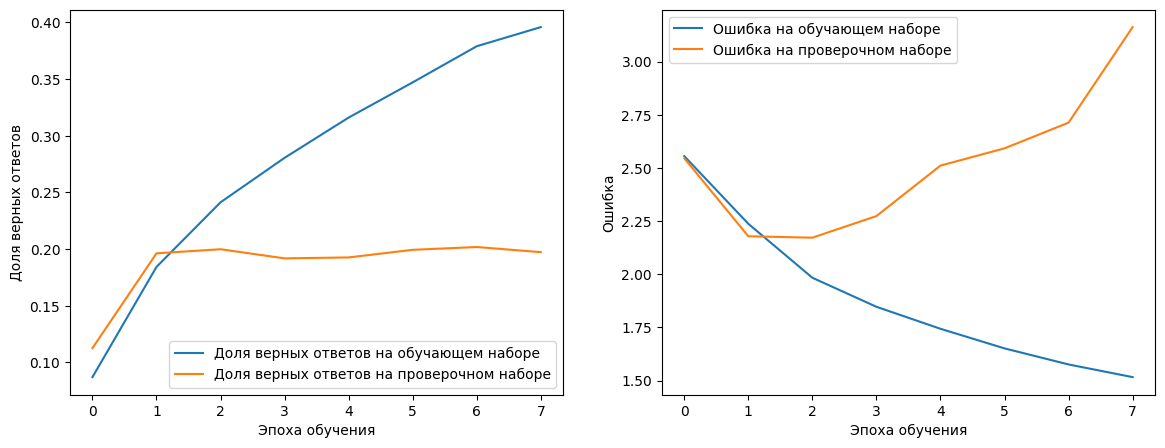

In [ ]:
plot_history(history_cnn)

In [ ]:
# Метрики качества по классам, минимальные и средние метрики, Accuracy по топ-1, топ-2 и топ-2, матрица ошибок

def quality(model, y_true, x):
  y_true =  Label.inverse_transform(y_true)
  probs=model.predict(x)
  y_pred = np.array([np.argmax(i) for i in probs])
  y_pred =  Label.inverse_transform(y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  precision_avg = precision_score(y_true, y_pred, average='weighted')
  recall_avg = recall_score(y_true, y_pred, average='weighted')
  fscore_avg = f1_score(y_true, y_pred, average='weighted')
  report = precision_recall_fscore_support(y_true, y_pred)
  precision_min = report[0].min()
  recall_min = report[1].min()
  fscore_min = report[2].min()
  precision_dict = {'min': precision_min, 'avg': precision_avg}
  precision = pd.Series(precision_dict)
  recall_dict = {'min': recall_min, 'avg': recall_avg}
  recall = pd.Series(recall_dict)
  fscore_dict = {'min': fscore_min, 'avg': fscore_avg}
  fscore = pd.Series(fscore_dict)
  quality_df = pd.DataFrame({'precision':precision,'recall':recall,'f1-score':fscore})
  print(classification_report(y_true, y_pred))
  print()
  print(f'Accuracy: {accuracy:.4f}')
  print()
  print(quality_df)
  print()

  cm = confusion_matrix(y_true, y_pred, )
  fig, ax = plt.subplots(figsize=(14,8))
  cm_display = ConfusionMatrixDisplay(cm, ).plot(ax=ax)
  labels = Label.classes_
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  print(f'Accuracy по топ-2: {top_k_accuracy_score(y_true, probs, k=2):.6f}')

152/152 [==============================] - 5s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

              precision    recall  f1-score   support

   athletics       0.56      0.35      0.43       743
   autosport       0.29      0.16      0.21       790
  basketball       0.30      0.06      0.10       712
  boardgames       0.26      0.33      0.29       755
      esport       0.00      0.00      0.00       747
     extreme       0.15      0.14      0.15       778
    football       0.17      0.13      0.15       715
      hockey       0.18      0.12      0.15       737
martial_arts       0.13      0.52      0.21       763
   motosport       0.50      0.01      0.02       758
      tennis       0.17      0.34      0.23       750
  volleyball       0.49      0.15      0.23       737
winter_sport       0.17      0.27      0.21       700

    accuracy                           0.20      9685
   macro avg       0.26      0.20      0.18      9685
weighted avg       0.26      0.20      0.18      9685


Accuracy: 0.1999

     precision    recall  f1-score
min   0.000000  0.000000 

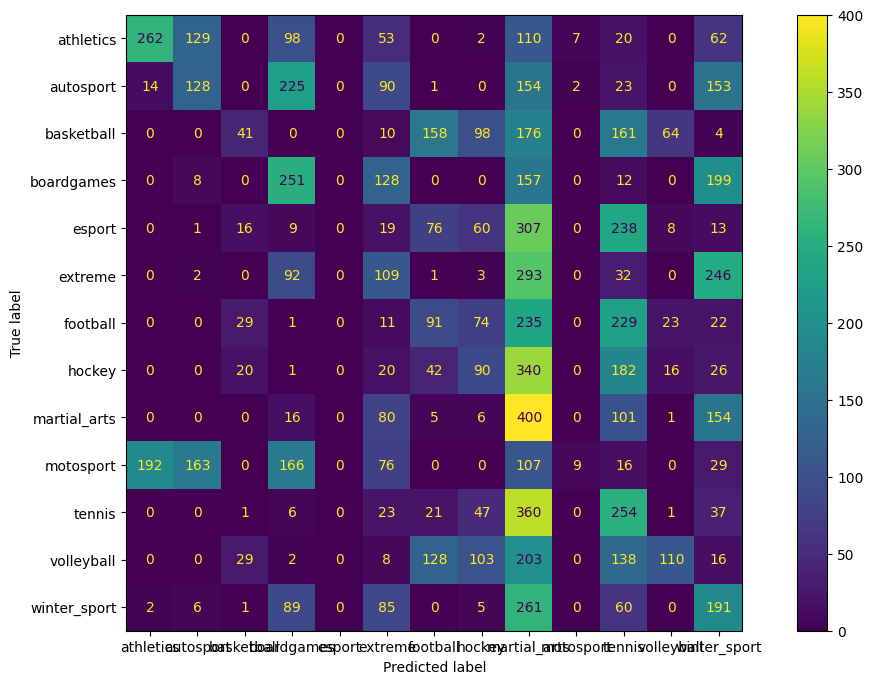

In [ ]:
quality(model_cnn, valid_labels, valid_ds)

## Реккурентная Сеть

In [ ]:
embedding_dim = 16

In [ ]:
model_lstm = keras.Sequential([
    layers.Embedding(vocab_size+1, embedding_dim),
    layers.LSTM(64, return_sequences = True),
    layers.LSTM(64),
    layers.Dense(16, activation='relu'),
    layers.Dense(13, activation='softmax')
])


In [ ]:
model_lstm.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [ ]:
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 16)          480016    
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          20736     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_14 (Dense)            (None, 16)                1040      
                                                                 
 dense_15 (Dense)            (None, 13)                221       
                                                                 
Total params: 535,037
Trainable params: 535,037
Non-trainable params: 0
_________________________________________________________________


1 эпоха обучения длится 45 минут, пришлось сократить до двух

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=10, restore_best_weights=True)]

history_lstm = model_lstm.fit(
    train_ds,
    epochs=2,
    validation_data=valid_ds,
    callbacks=callbacks
    )

Epoch 1/2
454/454 [==============================] - 2643s 6s/step - loss: 2.5649 - accuracy: 0.0789 - val_loss: 2.5645 - val_accuracy: 0.0816
Epoch 2/2
454/454 [==============================] - 2652s 6s/step - loss: 2.5646 - accuracy: 0.0816 - val_loss: 2.5644 - val_accuracy: 0.0816


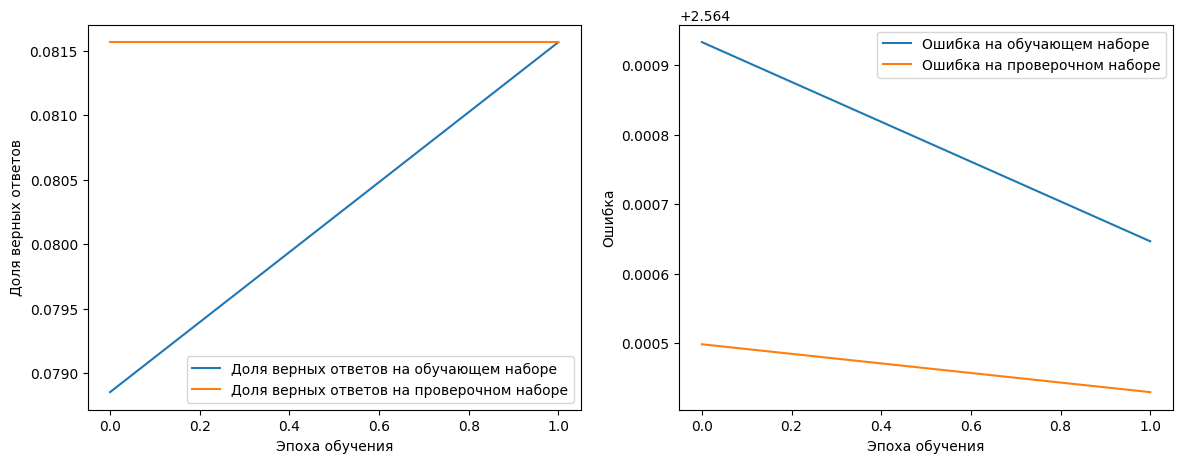

In [ ]:
plot_history(history_lstm)

152/152 [==============================] - 169s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

              precision    recall  f1-score   support

   athletics       0.00      0.00      0.00       743
   autosport       0.08      1.00      0.15       790
  basketball       0.00      0.00      0.00       712
  boardgames       0.00      0.00      0.00       755
      esport       0.00      0.00      0.00       747
     extreme       0.00      0.00      0.00       778
    football       0.00      0.00      0.00       715
      hockey       0.00      0.00      0.00       737
martial_arts       0.00      0.00      0.00       763
   motosport       0.00      0.00      0.00       758
      tennis       0.00      0.00      0.00       750
  volleyball       0.00      0.00      0.00       737
winter_sport       0.00      0.00      0.00       700

    accuracy                           0.08      9685
   macro avg       0.01      0.08      0.01      9685
weighted avg       0.01      0.08      0.01      9685


Accuracy: 0.0816

     precision    recall  f1-score
min   0.000000  0.000000 

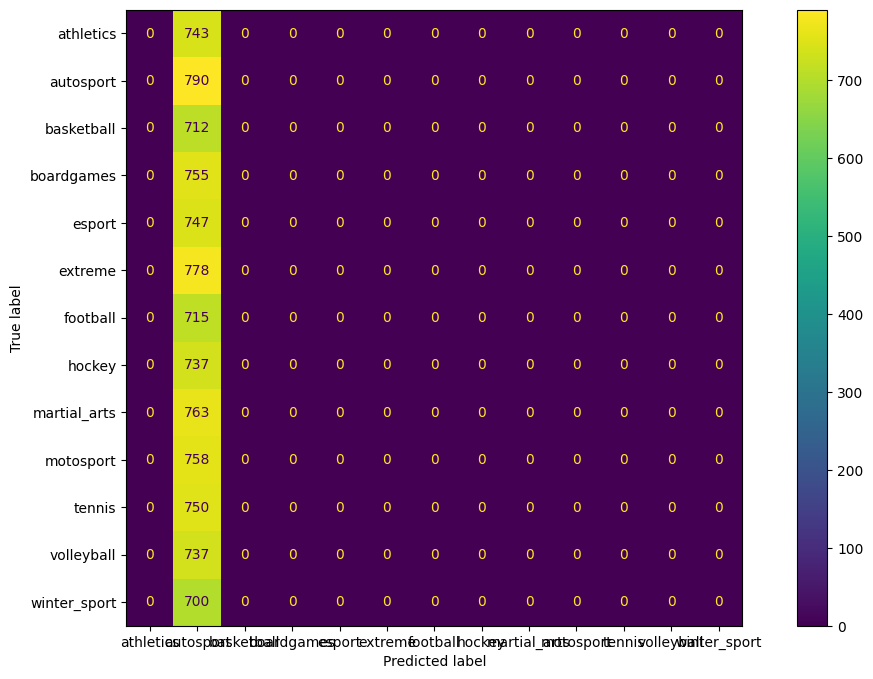

In [ ]:
quality(model_lstm, valid_labels, valid_ds)

Из-за малого количества эпох, крайне низкая метрика

## Посмотрим на влияние размера словаря и длины предложения

In [ ]:
vocab_size = 10000

In [ ]:
tok = Tokenizer(oov_token='<unk>',
                num_words = vocab_size)
tok.fit_on_texts(train_text)
tok.word_index['<pad>'] = 0
tok.index_word[0] = '<pad>'

In [ ]:
max_len = 1000

In [ ]:
train_seqs = return_seq(train_text, tok, max_len)

train_labels = Label_encoded_train

In [ ]:
valid_text = test_df['text'].to_numpy()

valid_seqs = return_seq(valid_text, tok, max_len)

valid_labels = Label_encoded_test

In [ ]:
# Переводим в формат TF Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_seqs,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_seqs,valid_labels))

# Делим Dataset на Batch
train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)

#  prefetch чтобы быстрее работало
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
embedding_dim = 16

In [ ]:
model_cnn = keras.Sequential([
    layers.Embedding(vocab_size+1, embedding_dim),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(3),
    layers.Conv1D(16, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(13, activation='softmax')
])


In [ ]:
model_cnn.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=2, restore_best_weights=True)]

history_cnn = model_cnn.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    callbacks=callbacks
    )

Epoch 1/20
454/454 [==============================] - 19s 39ms/step - loss: 2.4568 - accuracy: 0.1293 - val_loss: 2.5019 - val_accuracy: 0.1384
Epoch 2/20
454/454 [==============================] - 17s 39ms/step - loss: 2.0122 - accuracy: 0.2478 - val_loss: 2.0489 - val_accuracy: 0.2818
Epoch 3/20
454/454 [==============================] - 17s 39ms/step - loss: 1.7048 - accuracy: 0.3717 - val_loss: 1.8975 - val_accuracy: 0.3576
Epoch 4/20
454/454 [==============================] - 18s 40ms/step - loss: 1.4321 - accuracy: 0.4887 - val_loss: 1.8387 - val_accuracy: 0.4091
Epoch 5/20
454/454 [==============================] - 18s 39ms/step - loss: 1.1893 - accuracy: 0.5908 - val_loss: 1.9364 - val_accuracy: 0.4273
Epoch 6/20
454/454 [==============================] - 17s 37ms/step - loss: 1.0247 - accuracy: 0.6545 - val_loss: 2.2206 - val_accuracy: 0.4213
Epoch 7/20
454/454 [==============================] - 18s 39ms/step - loss: 0.9073 - accuracy: 0.7056 - val_loss: 2.6577 - val_accuracy:

152/152 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

   athletics       0.99      0.55      0.71       743
   autosport       0.92      0.31      0.47       790
  basketball       0.38      0.43      0.41       712
  boardgames       0.82      0.45      0.58       755
      esport       0.20      0.63      0.30       747
     extreme       0.33      0.29      0.31       778
    football       0.14      0.12      0.13       715
      hockey       0.76      0.46      0.57       737
martial_arts       0.17      0.40      0.24       763
   motosport       0.89      0.56      0.68       758
      tennis       0.68      0.54      0.60       750
  volleyball       0.64      0.40      0.49       737
winter_sport       0.31      0.18      0.22       700

    accuracy                           0.41      9685
   macro avg       0.56      0.41      0.44      9685
weighted avg       0.56      0.41      0.44      9685


Accuracy: 0.4091

     

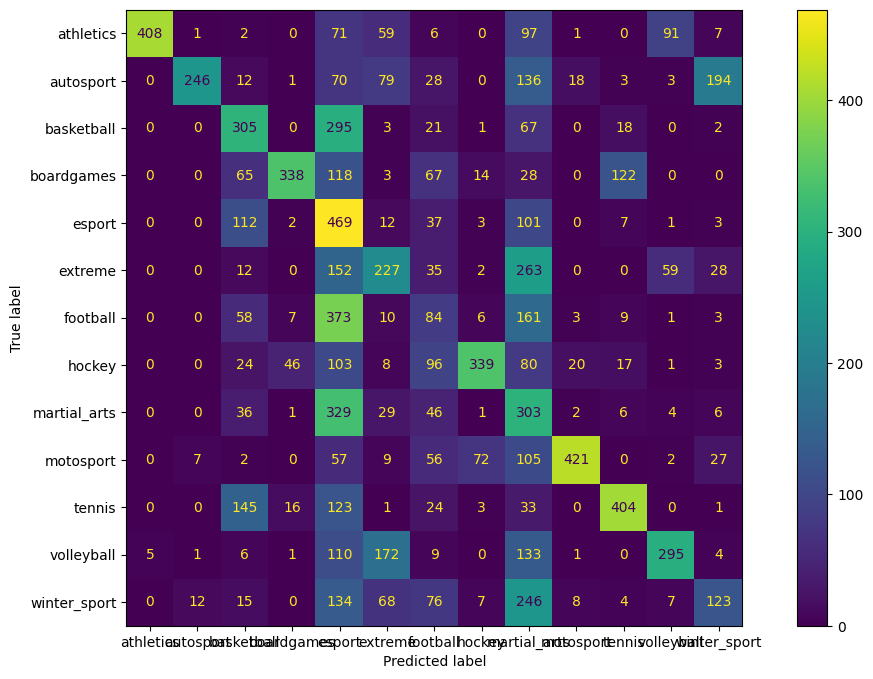

In [ ]:
quality(model_cnn, valid_labels, valid_ds)

При уменьшении размера словаря и длины предложения увеличилась точность предсказаний.
Однако точность классических моделей обучения оказалась выше.
Вероятно при оптимизации моделей, что позволило бы увеличить количесвто эпох обучения, точность моделей нейронных сетей бы увеличилась